# Introduction
The goal of this notebook is to generate a synthetic data set of from our lab's biophysics model of cardiac mechanics, hemodynamics, and growth called Monarch, and then match it using Bayesian History Matching (BHM). Here we simulate canine mitral valve regurgitation (MVR) and subsequent left ventricular (LV) remodeling due to volume overload. The synthetic data is generated by simulating a healthy canine heart, introducing MVR, and simulating the chronic phase of volume overload. The data is then fitted using BHM to estimate the parameters of the model, utilizing varying standard deviations within the synthetic data to determine the effect of data uncertainty on the calibration method. The notebook is divided into three main parts:
1. Generating the synthetic data
2. Running a sensitivity analysis and fitting the baseline model (pre-MVR)
3. Fitting the chronic model (post-MVR)

All data and simulations generated in this notebook will be stored on your local computer, you can change the directories if desired. Moreover, you can choose the confidence interval of the synthetic data, 10% (0.10) and 20% (0.20) of the mean were used in Jones & Oomen.

In [47]:
import pathlib

# Get notebook directory and store everything in a subdirectory
ci_data = 0.20  # Standard deviation of the data, change to 0.10 and 0.20 to obtain the results in Jones and Oomen 2024
root_dir = pathlib.Path().absolute() / str("synthetic_ci" + str(int(ci_data*100)) + "%")

# Set directory names
data_dir = root_dir / "data"
baseline_dir = root_dir / "baseline"
sensitivity_dir = root_dir / "sensitivity"
growth_dir = root_dir / "growth"
growth_type = "transverse_goktepe"

# Enable automatically reloading modules when they have changed
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


When rerunning this notebook, set the run_sims variable to false to skip the simulation step and only run the GPEs and implausibility calculations. Simulations ran previously will be loaded and this will tremendously speed up the process.

In [48]:
run_sims = True


# Generating the synthetic data
## Baseline & acute simulations
The model is a system of ordinary differential equations (ODEs) that describes cardiac physiology, mechanics and growth. The model is described in detail in Jones and Oomen 2024. First, import the model (note that monarch and chameleon both needs to be installed and monarch should be your environment) and initialize it with the default parameters from an input file designed to simulate volume overload in canines: 

In [49]:
from monarch import Hatch

input_file = root_dir.parent.parent / "inputs" / "input_canine_vo"
monarch_baseline = Hatch(input_file)

We want to set a few constants to ensure a realistic wall geometry of all ventricles at all times. This is important because we only want to fit the LV parameters in this case, and want to have realistic geometries for the other chambers for every chosen parameter set. These constants include a ratio of midwall reference areas takes from [2], and the wall thicknesses of all other chambers than the LV at end-diastole from [3].

In [50]:
from monarch.utils import change_pars

model_constants = {"AmRefRfwRatio": 1.36, "AmRefSwRatio": 0.53, "AmRefLARatio": 0.70, "AmRefRARatio": 0.51,
                   "RfWth": 3.4, "LAWth": 3.9, "RAWth": 3.9, "SWth": 10.3,
                   "RfwVRatio": 0.584, "SwVRatio": 0.607, "LAWVRatio": 0.0924, "RAWVRatio": 0.0410}

change_pars(monarch_baseline, model_constants)

Now we run the baseline simulation: a health canine heart with no mitral valve regurgitation. The results will be stored to enable later analysis and plotting.

In [51]:
# Run baseline simulation and store results to enable plotting results
baseline_file = "baseline"
monarch_baseline.just_beat_it(print_solve=False, file_path=data_dir, file_name=baseline_file, use_converged=False)

We can now run an acute simulation, where we introduce mitral valve regurgitation by decreasing the mitral valve backflow resistance, thus allowing more blood to flow back from the left ventricle into the left atrium. We will store the results in a separate model instance and export directory.

In [52]:
monarch_acute = Hatch(input_file)

# Create mitral valve regurgitation
pars_acute = {"Rmvb": 0.3}
change_pars(monarch_acute, pars_acute)

# Run acute simulation
acute_file = "acute"
monarch_acute.just_beat_it(print_solve=False, file_path=data_dir, file_name=acute_file, use_converged=False)

Now plot the results of these simulations, i.e. the pressure-volume loops of the left ventricle. Rerun the previous two and the current cell with different values for the mitral valve backflow resistance to see how the loops change. Add more parameters to the constants dictionaries or tweak the input file directly to change any other parameters.

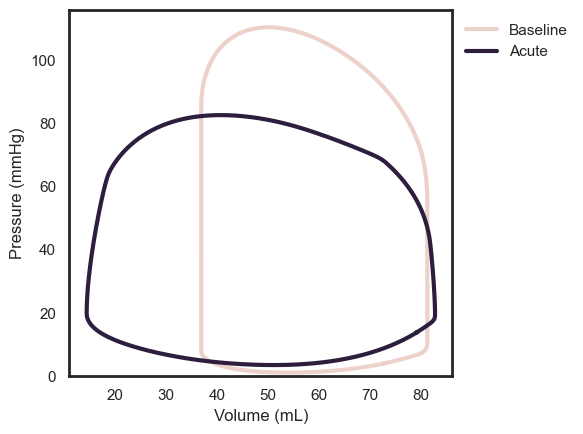

In [53]:
import monarch.metamorphoses as meta

meta.pv_loops([monarch_baseline, monarch_acute], model_names=("Baseline", "Acute"))

  ## Chronic simulation
Now we want to simulate the chronic phase of volume overload. The input file is set up to run 90 days of volume overload with constant hemodynamic parameters.

In [54]:
# Run chronic simulation
monarch_growth = Hatch(input_file)

# MOTIVATION WHY THICKENING SLOWER: Requires synthesis of entire new myofibril, and myocytes length is greater than width
pars_growth = {"tau_f+": 1.0, "tau_r-": 5.0, "tau_f-": 1e5, "tau_r+": 1e5, "gamma": 2.0, "t_mem": 1e5, 
               "theta_f_max": 1.5**2, "theta_f_min": 0.75, "theta_r_max": 1.5, "theta_r_min": 0.75,}

# Combine pars_growth and pars_acute
pars_acute.update(pars_growth)

# Set hemodynamic parameters
monarch_growth.growth.rmvb[1:] = pars_acute["Rmvb"]

growth_file = "chronic"
monarch_growth.change_pars(pars_acute)
monarch_growth.let_it_grow(file_path=data_dir, file_name=growth_file, use_converged=False)

Plot the changes in PV loops and metrics of the left ventricle over time.

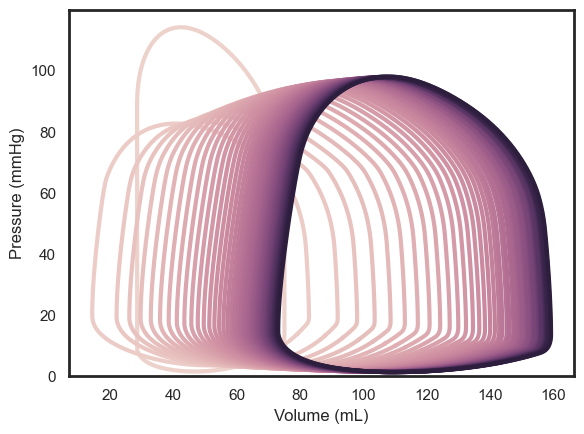

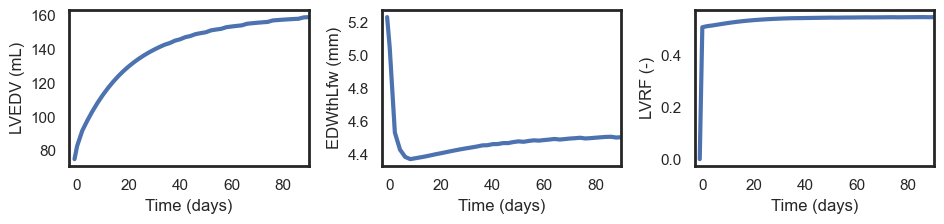

In [55]:
meta.pv_loop_growth(monarch_growth, file_path=str(data_dir), file_name=growth_file, show_fig=True)
meta.plot_growth(monarch_growth, ["LVEDV", "EDWthLfw", "LVRF"], units=["mL", "mm", "-"])

Besides the cardiac physiology, we should also inspect the growth of the ventricular walls. We can do this by plotting the fiber and cross-fiber growth, leading to wall dilation and thinning, resp. in this case.

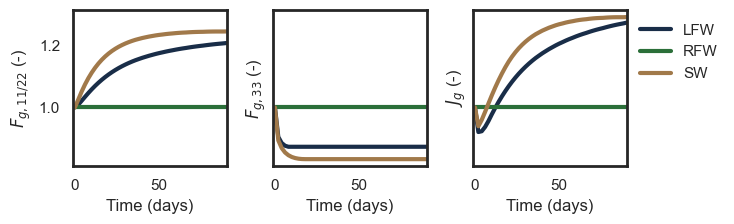

In [56]:
# Plot growth
meta.plot_fg(monarch_growth, file_path=str(data_dir), file_name=growth_file, show_fig=True)

## Extracting the data
We want to extract the data from the growth simulation to use it for fitting. We can do this by extracting certain values of interest from the *outputs* table in the model instance at certain time points. Setting certain mu values to NaN will exclude them from the fitting process; for example, we want to exclude the regurgitant fraction from the baseline model since it will always be almost 0.

In [57]:
import pandas as pd
import numpy as np

# Outputs of interest
y_labels = ["LVEDV", "LVESV", "LVEF", "LVEDP", "MAP", "EDWthLfw", "LVRF"]

# Time points of interest
t = [-1, 0, 30, 60, 90]

# Obtain outputs of interest from the growth simulation 
# Time points -1 and 0 are equal to the baseline and acute simulations, resp.
data_mean = monarch_growth.growth.outputs[y_labels].loc[t]
data_mean.loc[-1, "LVRF"] = np.nan

# We here assume that the standard deviation is 10% of the mean
data_std = ci_data * abs(data_mean)

# Display table
print("Mean:")
display(data_mean)
print("Standard deviation:")
display(data_std)

Mean:


,LVEDV,LVESV,LVEF,LVEDP,MAP,EDWthLfw,LVRF
-1,75.118115,28.629778,0.618870,13.798671,72.547870,5.231814,NaN
0,82.861698,18.767398,0.773509,19.577601,52.364028,5.047920,0.509913
30,140.038093,62.863098,0.551100,15.252269,59.868002,4.436919,0.543060
60,153.677631,75.445343,0.509068,14.045946,60.333403,4.486213,0.547623
90,159.245175,80.639536,0.493614,13.655812,60.465733,4.503839,0.548750


Standard deviation:


,LVEDV,LVESV,LVEF,LVEDP,MAP,EDWthLfw,LVRF
-1,15.023623,5.725956,0.123774,2.759734,14.509574,1.046363,NaN
0,16.572340,3.753480,0.154702,3.915520,10.472806,1.009584,0.101983
30,28.007619,12.572620,0.110220,3.050454,11.973600,0.887384,0.108612
60,30.735526,15.089069,0.101814,2.809189,12.066681,0.897243,0.109525
90,31.849035,16.127907,0.098723,2.731162,12.093147,0.900768,0.109750


We can also set some metadata: lower and upper limits and categories. The limits represent physiological limits of each data point: any emulated value that falls outside of these values will be rejected. The categories are only used for plotting purposes.

In [58]:
# Set physiological limits (same for baseline and acute and add RF for acute)
data_meta = pd.DataFrame(index=['min', 'max'], columns=y_labels)
data_meta.loc['min'] = [10, 0, 0, 0, 25, 2, 0]
data_meta.loc['max'] = [200, 200, 1, 40, 250, 50, 1]
data_meta

,LVEDV,LVESV,LVEF,LVEDP,MAP,EDWthLfw,LVRF
min,10,0,0,0,25,2,0
max,200,200,1,40,250,50,1


### Baseline
The Wave class is expecting a Pandas dataframe with all information for each output variable, which we set up here. We need mu (mean) and sigma (standard deviation), and optional the lower and upper limits labeled as *min* and *max*, resp. The time point of needs to be specified by *_label*, for a non-growth simulation this can be *_baseline* and/or *_acute*. We provide a utility function to convert the data to this format:

In [59]:
from chameleon.utils import convert_data

roi_baseline = ["LVEDV", "LVESV", "LVEF", "LVEDP", "MAP", "EDWthLfw", "LVRF"]
t = [-1, 0]

# Convert data to Pandas dataframe
data_baseline = convert_data(data_mean[roi_baseline].loc[t], data_std[roi_baseline].loc[t], 
                                  meta=data_meta[roi_baseline], csv_dir=data_dir, csv_name="data_baseline")
data_baseline

,mu_baseline,mu_acute,sigma_baseline,sigma_acute,min,max
LVEDV,75.118115,82.861698,15.023623,16.572340,10,200
LVESV,28.629778,18.767398,5.725956,3.753480,0,200
LVEF,0.618870,0.773509,0.123774,0.154702,0,1
LVEDP,13.798671,19.577601,2.759734,3.915520,0,40
MAP,72.547870,52.364028,14.509574,10.472806,25,250
EDWthLfw,5.231814,5.047920,1.046363,1.009584,2,50
LVRF,NaN,0.509913,NaN,0.101983,0,1


### Growth
For growth, we only analyze the volumes and wall thickness, use the same utility function but specify the columns of interest and specify growth = True to get the correct format for a growth simulation, i.e. labels are _d# (growth day) instead of baseline/acute. 

In [60]:
roi_growth = ["LVEDV", "EDWthLfw", "LVEF"]
t = [-1, 0, 30, 60, 90]

# Convert data to Pandas dataframe
data_growth = convert_data(data_mean[roi_growth].loc[t], data_std[roi_growth].loc[t], growth=True,
                                  meta=data_meta[roi_growth], csv_dir=data_dir, csv_name="data_growth")
data_growth

,mu_d-1,mu_d0,mu_d30,mu_d60,mu_d90,sigma_d-1,sigma_d0,sigma_d30,sigma_d60,sigma_d90,min,max
LVEDV,75.118115,82.861698,140.038093,153.677631,159.245175,15.023623,16.572340,28.007619,30.735526,31.849035,10,200
LVESV,28.629778,18.767398,62.863098,75.445343,80.639536,5.725956,3.753480,12.572620,15.089069,16.127907,0,200
EDWthLfw,5.231814,5.047920,4.436919,4.486213,4.503839,1.046363,1.009584,0.887384,0.897243,0.900768,2,50
LVEF,0.618870,0.773509,0.551100,0.509068,0.493614,0.123774,0.154702,0.110220,0.101814,0.098723,0,1


# Fitting the baseline model
## Setting up the Wave class
We will use the Wave class to fit the baseline/acute model. This class is designed to fit a model to a set of data points using Bayesian History Matching. First, we decide what parameters to fit and what their expected ranges are, and compile them in a list of dictionaries (one for each parameter). It is important that the labels match (case-insensitive) the label names in the monarch change_pars function. We also store the true values of the parameters, just to compare them with the fitted values later, this will not effect the fitting process.

In [61]:
pars = {
        "SAct": {"limits": [0.050, 0.200], "target": monarch_baseline.heart.sf_act[0]},
        "AmRefLfw": {"limits": [4e3, 10e3], "target": monarch_baseline.heart.am_ref[0]},
        "c3": {"limits": [5e-6, 5e-3], "target": monarch_baseline.heart.c_3[0]},
        "VLfw": {"limits": [40e3, 70e3], "target": monarch_baseline.heart.vw[0]},
        "SBV": {"limits": [300, 1500], "target": monarch_baseline.circulation.sbv},
        "Ras": {"limits": [0.3, 5.0], "target": monarch_baseline.resistances.ras},
        "Rmvb_acute": {"limits": [0.05, 2.0], "target": monarch_acute.resistances.rmvb}
    }

# Store target values in csv file
pd.DataFrame([p["target"] for p in pars.values()], index=[p for p in pars], columns=["True"]).to_csv(data_dir / "x_target_baselineacute.csv")

## Global sensitivity analysis
Before running the BHM, it is good practice to perform a sensitivity analysis. This can help you identify parameters or readouts that are irrelevant to the fitting process, and thus can be excluded from the fitting process. We will use the SALib package to perform a Sobol sensitivity analysis. In most models, performing a global sensitivity analysis is computationally expensive, so here take advantage of the low computational cost of the emulators to perform the analysis. Make sure to run sufficient simulations to properly train the emulators. Moreover, use enough emulation points to get a good estimate of the Sobol indices. A minimum of 2^11 = 2048 is generally recommended in the literature for this, so we go on order higher just to be sure. You can set run_sims to false if rerunning this cell/notebook. Note that some simulations may not convergence because of unrealistic parameter choices in this initial parameter space.

In [62]:
from chameleon.camouflage import Camouflage
import chameleon.monarch_utils as model_utils

data_baseline = pd.read_csv(root_dir / data_dir / "data_baseline.csv", index_col=0)

# Setting up the wave class
camo = Camouflage(0, sensitivity_dir, 5.0, pars, data_baseline, nroy=None, n_sim=2**8,
            clear_log=True, n_emu0=2**12, n_emu_min=2**12)

# Run simulations for all parameter sets in current wave set x to train the emulators
camo.x_sim, camo.y_sim, _ = model_utils.run_forest_run(camo, input_file, [], run_sims=run_sims,
                                                              constants=model_constants, log_file=camo.log_file)

-----------
Parameters:
-----------
- SAct: [0.05 - 0.2]
- AmRefLfw: [4000.0 - 10000.0]
- c3: [5e-06 - 0.005]
- VLfw: [40000.0 - 70000.0]
- SBV: [300.0 - 1500.0]
- Ras: [0.3 - 5.0]
- Rmvb_acute: [0.05 - 2.0]


-------------
Observations:
-------------
- LVEDV: 75.11811457235598 ± 15.023622914471195
- LVESV: 28.629777707858576 ± 5.725955541571715
- LVEF: 0.6188698575457251 ± 0.123773971509145
- LVEDP: 13.798671352956251 ± 2.75973427059125
- MAP: 72.54787030374086 ± 14.509574060748172
- EDWthLfw: 5.231813672285395 ± 1.0463627344570792
- LVEDV_acute: 82.86169750764996 ± 16.572339501529992
- LVESV_acute: 18.76739815715209 ± 3.753479631430418
- LVEF_acute: 0.7735093689648412 ± 0.1547018737929682
- LVEDP_acute: 19.577600854644416 ± 3.9155201709288834
- MAP_acute: 52.36402847713596 ± 10.472805695427192
- EDWthLfw_acute: 5.0479201237916245 ± 1.009584024758325
- LVRF_acute: 0.5099133115614672 ± 0.1019826623122934


-------------
Constants:
-------------
None specified


-------------
Parameter 

In [63]:
# Wrapper to run gpe_training_validation and sobol_sensitivity
camo.surf_sensitivity()

Training GPEs using PyTorch...
Performing sensitivity analysis...
Emulating 4096 points...
Emulation completed in 6.0 seconds


/Users/beatlab/miniconda3/envs/monarch/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


Now we plot the results of the global sensitivity analysis.

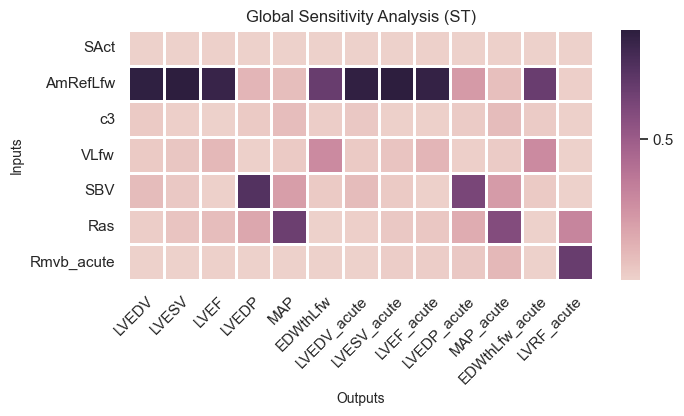

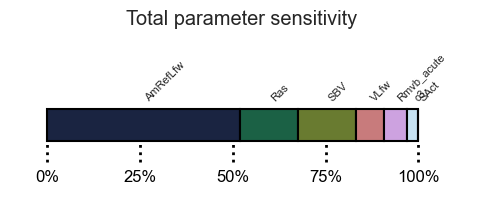

In [64]:
from chameleon.colors import TrueColors

# Start plotting class
colors = TrueColors(sensitivity_dir)

# Plot sensitivity matrix and total indices
colors.plot_sensitivity_matrix(show_fig=True)
colors.plot_sensitivity_total(show_bar=True, cutoff=1.0)

Based on this, we can exclude the parameter c_3 from the fitting process, since it is not sensitive to any of the outputs.

In [65]:
pars.pop("c3")
print(pars)

{'SAct': {'limits': [0.05, 0.2], 'target': np.float64(0.15)}, 'AmRefLfw': {'limits': [4000.0, 10000.0], 'target': np.int64(6000)}, 'VLfw': {'limits': [40000.0, 70000.0], 'target': np.int64(40800)}, 'SBV': {'limits': [300, 1500], 'target': 1000}, 'Ras': {'limits': [0.3, 5.0], 'target': 1.1}, 'Rmvb_acute': {'limits': [0.05, 2.0], 'target': 0.3}}


## Running a full BHM scheme
We now run the entire BHM process, this will take several minutes, depending on your computer. Note that several simulation in the early waves will crash because some very unrealistic parameter sets are included, but in later waves the model will behave much better since only non-implausible parameters sets are retained.

In [66]:
# Import csv file data as pandas dataframe and first column as index
data_baseline = pd.read_csv(root_dir / data_dir / "data_baseline.csv", index_col=0)

# Initialize wave index
i_wave = 0
nroy = None
not_flooded = True
sim_dirs = []

# Start history matching until convergence is reached
while not_flooded:

    # Set wave threshold: start with 5.0 and reduce incrementally with steps of 0.5 until 2.0
    wave_threshold = max(5 - 1*i_wave, 2)
    
    # Initialize wave    
    camo = Camouflage(i_wave, baseline_dir, wave_threshold, pars, data_baseline, nroy=nroy, clear_log=(i_wave == 0), 
                constants=model_constants)

    # Run simulations for all parameter sets in current wave set
    camo.x_sim, camo.y_sim, sim_dirs = model_utils.run_forest_run(camo, input_file, sim_dirs,constants=model_constants, 
                                                                  log_file=camo.log_file, run_sims=run_sims)

    # Run wave: train/validate emulators, emulate, calculate implausibility, find NROY
    camo.surf()

    # Check for convergence, store NROY from this wave as NROY for the next wave and update counter
    not_flooded = camo.is_flooded(i_wave, min_waves=4, max_waves=5)
    nroy = camo.nroy
    i_wave += 1

-----------
Parameters:
-----------
- SAct: [0.05 - 0.2]
- AmRefLfw: [4000.0 - 10000.0]
- VLfw: [40000.0 - 70000.0]
- SBV: [300.0 - 1500.0]
- Ras: [0.3 - 5.0]
- Rmvb_acute: [0.05 - 2.0]


-------------
Observations:
-------------
- LVEDV: 75.11811457235598 ± 15.023622914471195
- LVESV: 28.629777707858576 ± 5.725955541571715
- LVEF: 0.6188698575457251 ± 0.123773971509145
- LVEDP: 13.798671352956251 ± 2.75973427059125
- MAP: 72.54787030374086 ± 14.509574060748172
- EDWthLfw: 5.231813672285395 ± 1.0463627344570792
- LVEDV_acute: 82.86169750764996 ± 16.572339501529992
- LVESV_acute: 18.76739815715209 ± 3.753479631430418
- LVEF_acute: 0.7735093689648412 ± 0.1547018737929682
- LVEDP_acute: 19.577600854644416 ± 3.9155201709288834
- MAP_acute: 52.36402847713596 ± 10.472805695427192
- EDWthLfw_acute: 5.0479201237916245 ± 1.009584024758325
- LVRF_acute: 0.5099133115614672 ± 0.1019826623122934


-------------
Constants:
-------------
- AmRefRfwRatio: 1.36
- AmRefSwRatio: 0.53
- AmRefLARatio: 0.7


/Users/beatlab/Projects/monarch/src/monarch/heart.py:298: RuntimeWarning: invalid value encountered in scalar power
  am_m_lv = np.pi ** (1 / 3) * (6 * v_m_lv) ** (2 / 3)
/Users/beatlab/Projects/monarch/src/monarch/heart.py:304: RuntimeWarning: invalid value encountered in scalar power
  h_s = (model.heart.am_ref_w[2] * lab ** 2) / (2 * np.pi * ((3 * v_m_lv) / (4 * np.pi)) ** (1 / 3))
/Users/beatlab/Projects/monarch/src/monarch/heart.py:307: RuntimeWarning: invalid value encountered in scalar power
  r_m = ((3 * v_m_lv) / (4 * np.pi)) ** (1 / 3)


128 simulation pairs (baseline + acute) completed in 10.65 seconds
126 Simulations reached convergence
91 Simulations added to training data
Training GPEs using PyTorch...
Emulating 1048576 points...
Emulation completed in 4.18 seconds
362807 points remaining in NROY region (34.6% of original space)
LVESV_acute is the most implausible output (38.81% of all points)
191752 points remaining in NROY region after limits check
NROY size change at Wave 1 is -0.82: no convergence

------
Wave 2
------
Running 128 model simulations...
128 simulation pairs (baseline + acute) completed in 9.22 seconds
128 Simulations reached convergence
99 Simulations added to training data
Training GPEs using PyTorch...
Emulating 191752 points...
Emulation completed in 1.55 seconds
106967 points remaining in NROY region (10.2% of original space)
LVESV_acute is the most implausible output (26.71% of all points)
103870 points remaining in NROY region after limits check
NROY size change at Wave 2 is -0.46: no conve

## Analyzing the results
Run and plot simulations using a randomly selected subset of the posterior distribution. Compare these results with the simulation results after we just ran the single wave with implausibility criterion of 5.0 to see the vast improvement.


---------
Posterior
---------
Running 256 model simulations...
256 simulation pairs (baseline + acute) completed in 13.33 seconds
256 Simulations reached convergence
226 Simulations added to training data


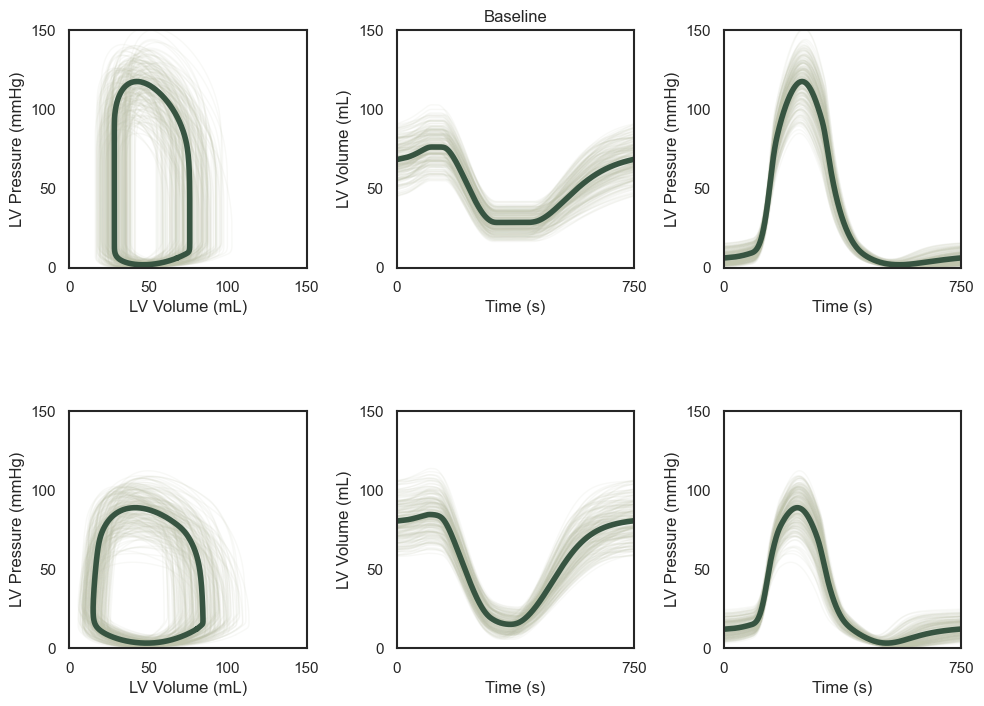

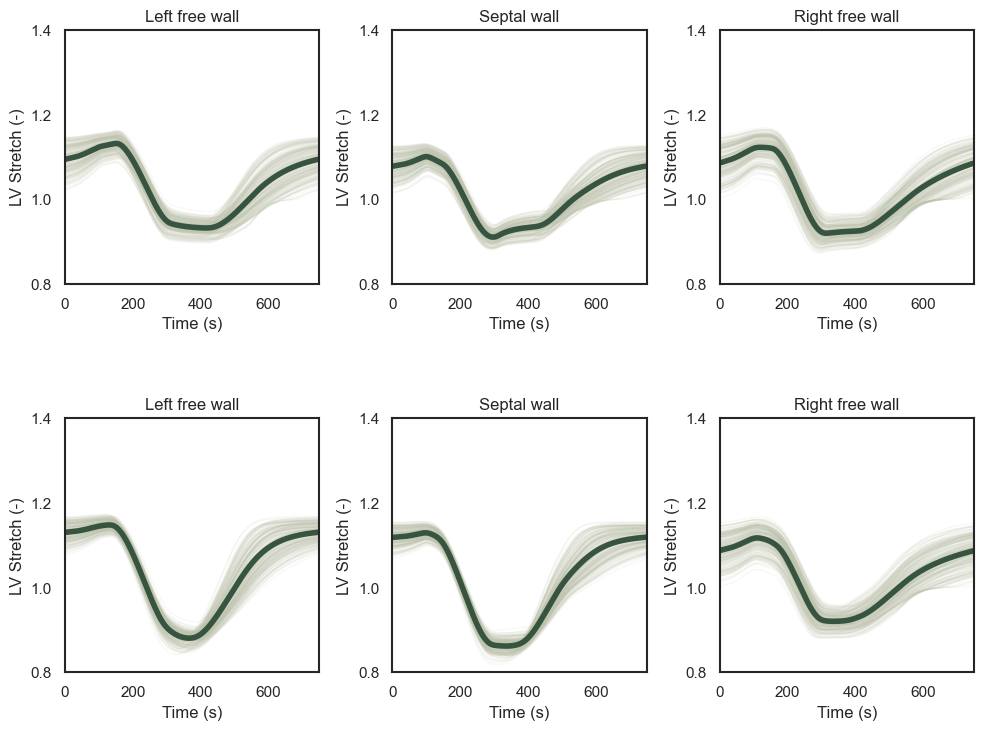

In [67]:
# Run simulations for all parameter sets in current wave set
x_posterior, y_posterior, _ = model_utils.run_forest_run(camo, input_file, [],  constants=model_constants, 
                                                         log_file=camo.log_file, show_fig=True, posterior=True)

In [68]:
camo.x_posterior, camo.y_posterior = x_posterior, y_posterior
camo.pickle_wave()

Now start the Tide class to further analyze the results. This class is designed to analyze the progression and final results of the fitting scheme. Because the Tide class is only dependent on the exported results from the Wave class, the following cell and all others in this section can be run independently of the rest of the notebook. First, always check if the final NROY region is within the 95% confidence interval of all data:

In [69]:
from chameleon.colors import TrueColors

colors = TrueColors(baseline_dir)

# Plot the convergence of the implausibility
colors.plot_nroy_data(show_box = True)

Next, inspect the final NROY region to inspect if all parameters are uniquely fitted, and if the mean of the matched distribution is close to the true values in this synthetic case. This plot is time-consuming to generate, so we here run it with a subset of 1000 randomly chosen parameter sets.

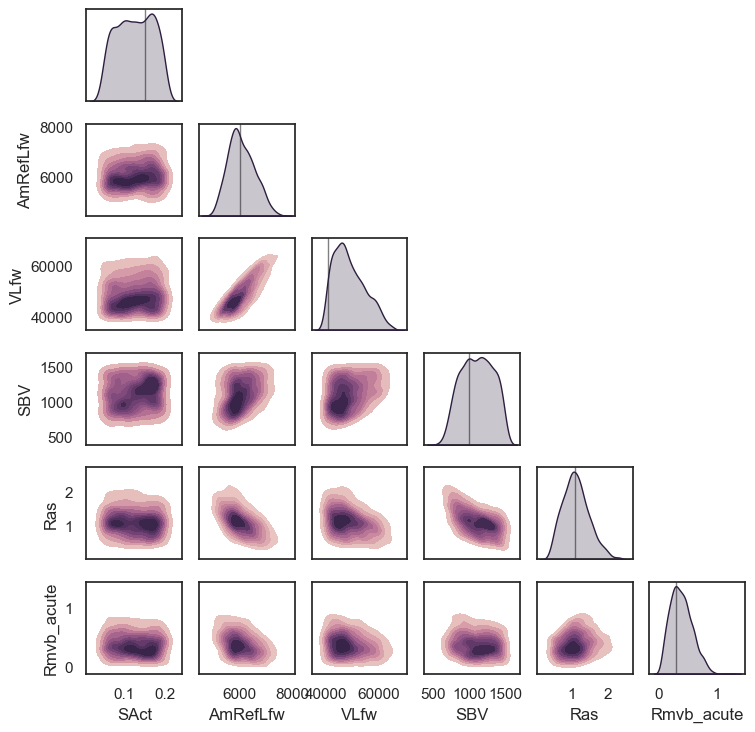

In [70]:
colors.plot_nroy_x(n_samples=1000, show_fig=True)

Run all plots, this will be time-consuming–in fact, it is slower than running BHM itself! The plots are saved in the *results* subdirectory.

In [71]:
import matplotlib.pyplot as plt
plt.close("all")
colors.roll(nroy_full=False)

# Fitting the growth model
## Running the BHM scheme
This is done similar to the baseline/acute model, but now we need to specify the growth parameters and the limits:

In [75]:
from chameleon.camouflage import Camouflage
import chameleon.monarch_utils as model_utils 

pars = {
    "tau_f+": {"limits": [0.1, 50.0], "target": monarch_growth.growth.tau_f_plus},
    "tau_r-": {"limits": [0.1, 50.0], "target": monarch_growth.growth.tau_r_min}
}

# Save target values in csv file
pd.DataFrame([p["target"] for p in pars.values()], index=[p for p in pars], columns=["True"]).to_csv(data_dir / "x_target_growth.csv")

model_constants.update({"tau_f-": 1e5, "tau_r+": 1e5, "gamma": 2.0, "t_mem": 1e5, "theta_f_max": 1.5**2, "theta_f_min": 0.75, "theta_r_max": 1.5, "theta_r_min": 0.75})

We also need to specify the prior directory, which is the directory where the baseline/acute model results are stored. This is needed to initialize the growth model with the correct geometry and hemodynamics. We will use the previous baseline fit.

In [ ]:
# Import csv file data as pandas dataframe and first column as index
data_growth = pd.read_csv(root_dir / data_dir / "data_growth.csv", index_col=0)

# Initialize wave index
i_wave = 0
nroy = None
not_flooded = True
sim_dirs = []

# Start history matching until convergence is reached
while not_flooded:

    # Set wave threshold: start with 5.0 and reduce incrementally with steps of 0.5 until 2.0
    wave_threshold = max(5 - 1*i_wave, 2)

    # Initialize wave
    camo = Camouflage(i_wave, growth_dir, wave_threshold, pars, data_growth, nroy=nroy, clear_log=(i_wave == 0), 
                constants=model_constants, prior_dir=baseline_dir)

    # Run simulations for all parameter sets in current wave set
    camo.x_sim, camo.y_sim, sim_dirs = model_utils.run_forest_run(camo, input_file, sim_dirs,  constants=model_constants, 
                                                                  log_file=camo.log_file, growth=True, run_sims=True)

    # Run wave: train/validate emulators, emulate, calculate implausibility, find NROY
    camo.surf()

    # Check for convergence, store NROY from this wave as NROY for the next wave and update counter
    not_flooded = camo.is_flooded(i_wave, min_waves=4, max_waves=5)
    nroy = camo.nroy
    i_wave += 1

-----------
Parameters:
-----------
- tau_f+: [0.1 - 50.0]
- tau_r-: [0.1 - 50.0]


-------------
Observations:
-------------
- LVEDV_d-1: 75.11811457235598 ± 15.023622914471195
- LVESV_d-1: 28.629777707858576 ± 5.725955541571715
- EDWthLfw_d-1: 5.231813672285395 ± 1.0463627344570792
- LVEF_d-1: 0.6188698575457251 ± 0.123773971509145
- LVEDV_d0: 82.86169750764996 ± 16.572339501529992
- LVESV_d0: 18.76739815715209 ± 3.753479631430418
- EDWthLfw_d0: 5.0479201237916245 ± 1.009584024758325
- LVEF_d0: 0.7735093689648412 ± 0.1547018737929682
- LVEDV_d30: 140.0380931561387 ± 28.007618631227743
- LVESV_d30: 62.86309842961772 ± 12.572619685923543
- EDWthLfw_d30: 4.4369193863850365 ± 0.8873838772770073
- LVEF_d30: 0.5511000113410066 ± 0.1102200022682013
- LVEDV_d60: 153.67763075155435 ± 30.735526150310875
- LVESV_d60: 75.44534272185739 ± 15.08906854437148
- EDWthLfw_d60: 4.486213255707488 ± 0.8972426511414977
- LVEF_d60: 0.5090675047962744 ± 0.1018135009592548
- LVEDV_d90: 159.24517539507394 ± 3

## Analyzing the results
Run posterior simulations and plot the results:

In [ ]:
# Run simulations for all parameter sets in current wave set
x_posterior, y_posterior, _ = model_utils.run_forest_run(camo, input_file, [],  constants=model_constants, growth=True, 
                                                         log_file=camo.log_file, show_fig=False,
                                                         posterior=True, run_sims=True)

In [ ]:
from chameleon.colors import TrueColors

camo.x_posterior, camo.y_posterior = x_posterior, y_posterior
camo.pickle_wave()

colors = TrueColors(growth_dir)

In [ ]:
import seaborn as sns

# PLot distribution of growth parameters
g = sns.jointplot(x=camo.nroy[:, 0], y=camo.nroy[:, 1], kind="kde", cmap=sns.cubehelix_palette(as_cmap=True), 
              fill=True, thresh=0.05, color='k', log_scale=(False, False),
              joint_kws={"bw_adjust": 1.0}, 
              marginal_kws={"bw_adjust": 1.0}, height=5)

g.refline(x=camo.x_target[0], y=camo.x_target[1], color='k', ls='--')

plt.xlabel(r"$\tau_{f+}$")
plt.ylabel(r"$\tau_{r-}$")
plt.savefig(growth_dir / "Results" / "nroy_tau.pdf", bbox_inches='tight')
plt.show()

Create all remaining plots.

In [ ]:
colors.roll(nroy_full=False)